# Clearing the dbfs environment & making it ready to accomodate new dataframes

In [0]:
# Clear the cache
spark.catalog.clearCache()

# Setup

In [0]:
# Importing necessary libraries for data visualization
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Importing necessary libraries for working with PySpark dataframes
import pyspark.sql.functions as func
from pyspark.sql.window import Window
from pyspark.sql.functions import udf

# Setting the year to make the code reusable
year = "2021"

# Setting the directory paths for the data files
# Constructing the file path for the clinical data using the year variable
clinical_data_file_path = f"/FileStore/tables/clinicaltrial_{year}.csv"
pharma_data_file_path = "/FileStore/tables/pharma.csv"

# Checking if the data files exist in the Databricks filestore
try:
    dbutils.fs.ls(clinical_data_file_path)
    dbutils.fs.ls(pharma_data_file_path)
    print(f"clinicaltrial_{year}.csv and pharma.csv both exist in the Databricks filestore at the following paths:")
    print(f"{clinical_data_file_path}")
    print(f"{pharma_data_file_path}")
    print("You\'re good to proceed")
except:
    print(f"clinicaltrial_{year}.csv does not exist in the Databricks filestore.")
    print(f"But pharma.csv exists in the Databricks filestore at {pharma_data_file_path}")

clinicaltrial_2021.csv and pharma.csv both exist in the Databricks filestore at the following paths:
/FileStore/tables/clinicaltrial_2021.csv
/FileStore/tables/pharma.csv
You're good to proceed


# Ingesting the datasets

### Clinical Data

In [0]:
# Read the CSV file into a PySpark DataFrame using the provided file path
# The csv file is pipe('|')-separated with the first row as the header and the schema is inferred from the data
clinical_data = spark.read.csv(clinical_data_file_path,
                              sep = "|",
                              header = True,
                              inferSchema = True)

# Display the top 5 rows of the clinical data DataFrame
# truncate=False is used to display all the columns without truncation
clinical_data.show(5, truncate = False)

+-----------+--------------------------------------+----------------------+--------+----------+--------------------------------+----------+-------------------------------------------------+-------------+
|Id         |Sponsor                               |Status                |Start   |Completion|Type                            |Submission|Conditions                                       |Interventions|
+-----------+--------------------------------------+----------------------+--------+----------+--------------------------------+----------+-------------------------------------------------+-------------+
|NCT02758028|The University of Hong Kong           |Recruiting            |Aug 2005|Nov 2021  |Interventional                  |Apr 2016  |null                                             |null         |
|NCT02751957|Duke University                       |Completed             |Jul 2016|Jul 2020  |Interventional                  |Apr 2016  |Autistic Disorder,Autism Spectrum Disorder   

### Pharma Data

In [0]:
# Read the csv file from the specified file path and create a PySpark DataFrame object named pharma_data
# The csv file is comma(',')-separated with the first row as the header and the schema is inferred from the data
pharma_data = spark.read.csv(pharma_data_file_path,
                            sep = ',',
                            header = True,
                            inferSchema = True
                            )

# Display the PySpark DataFrame in a tabular format with all columns shown without truncation
pharma_data.show(5)

+--------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------+--------------------+------------------+---------------------+-----+-------+-----------------------------+------------------+--------------+--------+-------+----+----------+--------------------+--------------------+------------------+-------------------+---------------------------+------------------------+---------------------------+--------------------+--------------------+
|             Company|     Parent_Company|Penalty_Amount|Subtraction_From_Penalty|Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting|Penalty_Year|Penalty_Date|       Offense_Group|     Primary_Offense|   Secondary_Offense|         Description|Level_of_Government|  Action_Type|              Agency|    Civil/Criminal|Prosecution_Ag

# Question 1

#### What is the number of studies in the clinical data dataset?

In [0]:
# Count the number of rows in the clinical data PySpark dataframe
clinical_data.count()

Out[13]: 387261

In [0]:
# Counting the distinct number of rows in clinical_data dataframe
distinct_count = clinical_data.distinct().count()

# Printing the distinct count of the studies
print(f"Distinct number of studies: {distinct_count}")

Distinct number of studies: 387261


# Defining a user-defined function

In [0]:
# Defining a user-defined function to automate the repititive grouping and counting in the problems
def group_and_count(data, column, top_n=5):
    """
    Groups the input data by the specified column and counts the number of occurrences of each value.
    Displays the top n results without truncating the output.

    Parameters:
    -----------
    data : pyspark.sql.DataFrame
        The input data to be grouped and counted.
    column : str
        The column name to group the data by.
    top_n : int
        The number of top results to display (default 5).

    Returns:
    --------
    None
    """
    # Grouping the data by the specified column and counting the number of occurrences of each value
    result = (data.groupBy(column)
    .count()
    .orderBy(func.desc("count")))
    
    # Displaying the top n results without truncating the output
    result.show(top_n, truncate=False)

# Question 2

### What are the types of studies in the dataset and their occurrences?

In [0]:
# Using the group_and_count function to group the data by the "Type" column and count the number of occurrences of each value
group_and_count(clinical_data, "Type")

+--------------------------------+------+
|Type                            |count |
+--------------------------------+------+
|Interventional                  |301472|
|Observational                   |77540 |
|Observational [Patient Registry]|8180  |
|Expanded Access                 |69    |
+--------------------------------+------+



# Question 3

### What are the top 5 conditions and their occurrences?

In [0]:
# Grouping and counting the Conditions column
group_and_count(
    clinical_data.select("Conditions")  # Selecting only the Conditions column
    .na.drop()  # Dropping any rows with missing values
    .withColumn("Conditions", func.split("Conditions", ","))  # Splitting the Conditions column by comma
    .withColumn("Conditions", func.explode("Conditions")),  # Exploding the array of Conditions into individual rows
    "Conditions"  # Grouping the data by the Conditions column
)

+-----------------+-----+
|Conditions       |count|
+-----------------+-----+
|Carcinoma        |13389|
|Diabetes Mellitus|11080|
|Neoplasms        |9371 |
|Breast Neoplasms |8640 |
|Syndrome         |8032 |
+-----------------+-----+
only showing top 5 rows



# Question 4

### Which companies are the top 10 most common sponsors that are not pharmaceutical companies?

In [0]:
# First, selecting the Parent_Company column from the pharma_data DataFrame and collecting the values as a list
Parent_company = [row["Parent_Company"] for row in pharma_data.select("Parent_Company").collect()]

# Then, selecting the Sponsor column from the clinical_data DataFrame
common_sponsors = (clinical_data.select("Sponsor")
                    .filter(~func.col("Sponsor").isin(Parent_company)) # filter out rows where list of Sponsors is not in the Parent_company list
                    .groupBy("Sponsor") # grouping by Sponsor
                    .count() # counting their number of occurrences  
                    .orderBy(func.desc("count")) # order by count in descending order
                    .withColumn("S/N", func.row_number().over(Window.orderBy(func.monotonically_increasing_id()))) # add a serial number column
                    .select("S/N", "Sponsor", "count") # select only the relevant columns
                  )
# Finally, show the top 10 common sponsors without truncating the output
common_sponsors.show(10, truncate=False)

+---+---------------------------------------+-----+
|S/N|Sponsor                                |count|
+---+---------------------------------------+-----+
|1  |National Cancer Institute (NCI)        |3218 |
|2  |M.D. Anderson Cancer Center            |2414 |
|3  |Assistance Publique - Hôpitaux de Paris|2369 |
|4  |Mayo Clinic                            |2300 |
|5  |Merck Sharp & Dohme Corp.              |2243 |
|6  |Assiut University                      |2154 |
|7  |Novartis Pharmaceuticals               |2088 |
|8  |Massachusetts General Hospital         |1971 |
|9  |Cairo University                       |1928 |
|10 |Hoffmann-La Roche                      |1828 |
+---+---------------------------------------+-----+
only showing top 10 rows



# Question 5

### How many studies are completed per month in the given year?

In [0]:
# Defining a dictionary for the months of the year
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
              'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
# Defining a function to get the number corresponding to a given month name
def get_month_num(month_name):
    return month_dict[month_name]

# Creating a UDF(User-Defined Function) from the above function as required when working with spark dataframes
get_month_num_udf = udf(get_month_num)

# Selecting the columns 'Status' and 'Completion' from the clinical_data DataFrame
studies_pm = (clinical_data.select("Status", "Completion")
              .na.drop() # Dropping rows with missing values
              .filter(func.col("Status") == "Completed") # Filtering for only the rows with the 'Completed' status
              .withColumn("Month", func.split("Completion", " ").getItem(0)) # Extracting the month from the 'Completion' column and creating separate columns for them
              .withColumn("Year", func.split("Completion", " ").getItem(1)) # Extracting the year from the 'Completion' column and creating separate columns for them
              .filter(func.col("Year") == year) # Filtering the data for the given year
              .drop("Status", "Completion", "Year") # Dropping the 'Status', 'Completion', and 'Year' columns
              .groupBy("Month") # Grouping the data by month and counting the number of occurrences in each group
              .count()
              .withColumn("Month_Number", get_month_num_udf(func.col("Month"))) # Applying the UDF to get the numerical value for each month and adding it as a new column
              .withColumn("Month_Number", func.col("Month_Number").cast("int")) # Casting the new column to an integer type
              .orderBy(func.asc("Month_Number")) # Sorting the data by the numerical value of the months in ascending order
              .drop("Month_Number") # Dropping the numerical value column
             )
# Displaying the resulting DataFrame
studies_pm.show()

+-----+-----+
|Month|count|
+-----+-----+
|  Jan| 1131|
|  Feb|  934|
|  Mar| 1227|
|  Apr|  967|
|  May|  984|
|  Jun| 1094|
|  Jul|  819|
|  Aug|  700|
|  Sep|  528|
|  Oct|  187|
+-----+-----+



### Visualizing the studies

#### The data to be visualized

In [0]:
# The table of values to be plotted for each month
studies_pm.show()

+-----+-----+
|Month|count|
+-----+-----+
|  Jan| 1131|
|  Feb|  934|
|  Mar| 1227|
|  Apr|  967|
|  May|  984|
|  Jun| 1094|
|  Jul|  819|
|  Aug|  700|
|  Sep|  528|
|  Oct|  187|
+-----+-----+



### Graphical representation of the studies completed per month in the give year

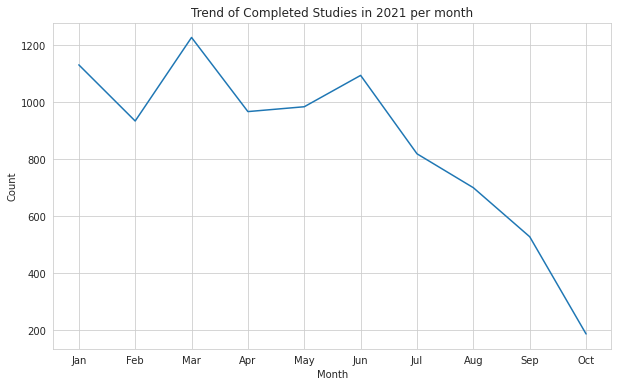

In [0]:
# Selecting the "Month" column from the studies_pm DataFrame using the select() method and storing it as a list
Month = [row["Month"] for row in studies_pm.select("Month").collect()]

# Selecting the "count" column from the studies_pm DataFrame using the select() method and storing it as a list
count = [row["count"] for row in studies_pm.select("count").collect()]

# Creating a Pandas DataFrame from the Month and Count lists
df = pd.DataFrame({'Month': Month, 'Count': count})

# Set the style of the plot using Seaborn
sns.set_style("whitegrid")

# Create a figure and set the size
plt.figure(figsize=(10, 6))

# Plot a bar chart using Seaborn
sns.lineplot(x="Month", y="Count", data=df)

# Set the title and axis labels
plt.title(f'Trend of Completed Studies in {year} per month')
plt.xlabel('Month')
plt.ylabel('Count')

# Display the plot
plt.show()

# Further Analysis

### What month(s) do most companies recruit individuals for clinical trials?

In [0]:
# Selecting the columns 'Status' and 'Completion' from the clinical_data DataFrame
next_step_pm = (clinical_data.select("Status", "Completion")
              .na.drop() # Dropping rows with missing values
              .filter(func.col("Status") == "Recruiting") # Filtering for only the rows with 'Status' equal to 'Recruiting'
              .withColumn("Month", func.split("Completion", " ").getItem(0)) # Extracting the month from the 'Completion' column and creating separate columns for them
              .withColumn("Year", func.split("Completion", " ").getItem(1)) # Extracting the year from the 'Completion' column and creating separate columns for them
              .filter(func.col("Year") == year) # Filtering the data for the given year
              .drop("Status", "Completion", "Year") # Dropping the 'Status', 'Completion', and 'Year' columns
              .groupBy("Month") # Grouping the data by month and counting the number of occurrences in each group
              .count()
              .withColumn("Month_Number", get_month_num_udf(func.col("Month"))) # Applying the UDF to get the numerical value for each month and adding it as a new column
              .withColumn("Month_Number", func.col("Month_Number").cast("int")) # Casting the new column to an integer type
              .orderBy(func.asc("Month_Number")) # Sorting the data by the numerical value of the months in ascending order
              .drop("Month_Number") # Dropping the numerical value column
             )

# Displaying the resulting DataFrame
next_step_pm.show()

+-----+-----+
|Month|count|
+-----+-----+
|  Jan|  278|
|  Feb|  235|
|  Mar|  420|
|  Apr|  402|
|  May|  430|
|  Jun|  828|
|  Jul|  680|
|  Aug|  725|
|  Sep| 1121|
|  Oct| 1156|
|  Nov| 1061|
|  Dec| 5566|
+-----+-----+



### Graphical representation

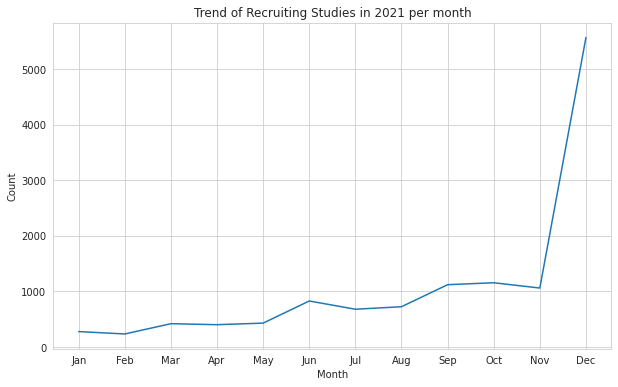

In [0]:
# Selecting the "Month" column from the next_step_pm DataFrame using the select() method and storing it as a list
Month = [row["Month"] for row in next_step_pm.select("Month").collect()]

# Selecting the "count" column from the next_step_pm DataFrame using the select() method and storing it as a list
count = [row["count"] for row in next_step_pm.select("count").collect()]

# Creating a Pandas DataFrame from the Month and Count lists
df = pd.DataFrame({'Month': Month, 'Count': count})

# Set the style of the plot using Seaborn
sns.set_style("whitegrid")

# Create a figure and set the size
plt.figure(figsize=(10, 6))

# Plot a bar chart using Seaborn
sns.lineplot(x="Month", y="Count", data=df)

# Set the title and axis labels
plt.title(f'Trend of Recruiting Studies in {year} per month')
plt.xlabel('Month')
plt.ylabel('Count')

# Display the plot
plt.show()